# Import Libraties

In [52]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# data preprocessing

In [14]:
train = pd.read_csv('../input/cross-sell/train.csv')
test = pd.read_csv('../input/cross-sell/test.csv')
print('Shape train: {}'.format(train.shape))
print('Shape test: {}'.format(test.shape))


In [15]:
train.head()

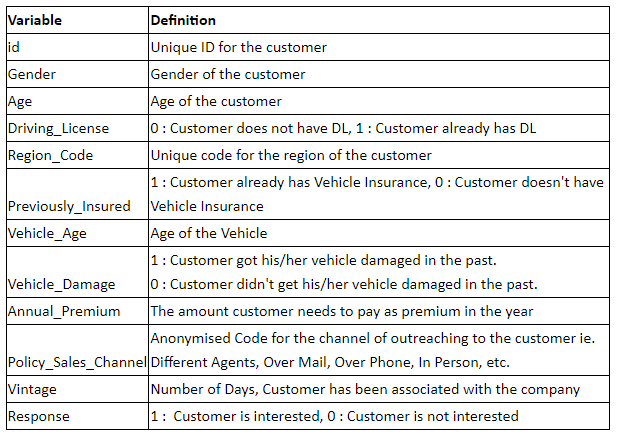

In [16]:
train['Response']= le.fit_transform(train['Response'])

In [17]:
train['Response'].value_counts().plot.pie(autopct = '%1.1f%%', colors = ['Red','Blue'], figsize = (5,5))

In [18]:
train.isna().sum()/ train.shape[0]*100

In [19]:
sns.countplot(train['Gender'], hue= train['Response'], palette = ['Red','Blue'])

In [20]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize = (30,10))
axx = ax.flatten()
sns.distplot(train['Age'], ax= axx[0], color ='Blue')
sns.boxplot(train['Age'], ax= axx[1], color ='Yellow')

In [21]:
age20_30 = train[train['Age'] < 31]
age31_40 = train[train['Age'].between(31,40)]
age41_50 = train[train['Age'].between(41,50)]
age51_60 = train[train['Age'].between(51,60)]
age61_more = train[train['Age'] > 60]
age_group = [age20_30, age31_40, age41_50, age51_60, age61_more]
age_group_name = ['age20_30', 'age31_40', 'age41_50', 'age51_60', 'age61_more']
age_group_dict = dict(zip(age_group_name, age_group))

f, ax = plt.subplots(nrows=2, ncols=3, figsize = (30,10))
axx = ax.flatten()
for pos, tup in enumerate(age_group_dict.items()):
    axx[pos].set_title(tup[0])
    data=tup[1]
    data['Response'].value_counts().plot.pie(autopct = '%1.1f%%', ax =axx[pos], colors = ['Red','Blue'])

In [22]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize = (30,10))
axx = ax.flatten()
for pos, tup in enumerate(age_group_dict.items()):
    axx[pos].set_title(tup[0])
    temp=tup[1]
    temp.groupby('Gender')['Response'].value_counts().plot.pie(autopct = '%1.1f%%', ax =axx[pos], colors = ['Red','Blue'])

In [23]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
axx = ax.flatten()
axx[0].set_title('Driving_License = 0')
axx[1].set_title('Driving_License = 1')
train[train['Driving_License'] == 0]['Response'].value_counts().plot.pie(autopct = '%1.1f%%', ax=axx[0], colors = ['Red','Blue'])
train[train['Driving_License'] == 1]['Response'].value_counts().plot.pie(autopct = '%1.1f%%', ax=axx[1], colors = ['Red','Blue'])

In [24]:
plt.figure(figsize = (30,10))
plt.title('Region',fontsize = 50)
sns.countplot(train['Region_Code'], hue = train['Response'], palette=['Red','Blue'])

In [25]:
plt.figure(figsize = (30,10))
sns.countplot(train['Previously_Insured'], hue = train['Response'], palette=['Red','Blue'])

In [26]:
plt.figure(figsize = (30,10))
sns.countplot(train['Vehicle_Age'], hue = train['Response'], palette=['Red','Blue'])

In [27]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize = (30,10))
axx = ax.flatten()
Vehicle_Age_group = train['Vehicle_Age'].unique()
for pos, tup in enumerate(Vehicle_Age_group):
    axx[pos].set_title(tup)
    train[ train['Vehicle_Age'] == tup]['Response'].value_counts().plot.pie(autopct = '%1.1f%%', ax =axx[pos], colors = ['Red','Blue'])

In [28]:
plt.figure(figsize = (30,10))
sns.countplot(train['Vehicle_Damage'], hue = train['Response'], palette=['Red','Blue'])

In [29]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize = (30,10))
axx = ax.flatten()
sns.distplot(train['Annual_Premium'], ax= axx[0], color ='Blue')
sns.boxplot(train['Annual_Premium'], ax= axx[1], color ='Yellow')

In [30]:
train[train['Annual_Premium'] > 100000].shape

In [31]:
train[train['Annual_Premium'] > 100000].shape[0] / train.shape[0] * 100

In [32]:
plt.figure(figsize = (30,10))
sns.distplot(train[train['Annual_Premium'] < 100000]['Annual_Premium'], color ='Blue')

In [33]:
plt.figure(figsize = (30,10))
sns.distplot(train['Policy_Sales_Channel'], color ='Blue')

In [34]:
plt.figure(figsize = (30,10))
train['Policy_Sales_Channel'].value_counts().plot.bar()

In [35]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize = (30,10))
axx = ax.flatten()
sns.distplot(train['Vintage'], ax= axx[0], color ='Blue')
sns.boxplot(train['Vintage'], ax= axx[1], color ='Yellow')

# Concolution insights:
### age:
- 30-60 : buy more
- 20-30: buy less
- Male buy more in all age group
### 
...

# Correlation

In [36]:
train['is_train'] = 1
test['is_train'] = 0
test['Response'] = None

data = pd.concat((train, test))
data.set_index('id', inplace = True)
data.shape

In [37]:
corr_check = data.copy()

col_add = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
for col in col_add:
    corr_check[col] = le.fit_transform(corr_check[col])

plt.figure(figsize = (20,10))
sns.heatmap(corr_check.corr(), annot = True, square = True, annot_kws = {'size' : 10})

## Data Preprocessing 

In [38]:
train['Vehicle_Age']=train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
train['Vehicle_Damage']=train['Vehicle_Damage'].replace({'Yes':1,'No':0})

test['Vehicle_Age']=test['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
test['Gender']=test['Gender'].replace({'Male':1,'Female':0})
test['Vehicle_Damage']=test['Vehicle_Damage'].replace({'Yes':1,'No':0})

train['Region_Code']=train['Region_Code'].astype(int)
test['Region_Code']=test['Region_Code'].astype(int)
train['Policy_Sales_Channel']=train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel']=test['Policy_Sales_Channel'].astype(int)

In [46]:
model.feature_importances_

# Test model

In [39]:
features = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

cat_col =['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']

## Train test split

In [40]:
x_train = train[features]
y_train = train['Response']

X_train, X_test, Y_train, Y_test = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=.2, 
                                                    random_state=42,stratify=y_train,
                                                 shuffle = True)

## LGBM mode

In [41]:
model = LGBMClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]


In [42]:
print('LGBM Base accuracy: {}'.format(accuracy_score(Y_test, y_pred)))
print('LGBM Base ROC_AUC_SCORE: {}'.format(roc_auc_score(Y_test,proba)))

In [69]:
def objective(trial):

    lgbm = LGBMClassifier(objective='binary', random_state=22)
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators",1000,10000),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    lgbm.fit(X_train, Y_train)
    Y_pred = lgbm.predict(X_test) 
    proba = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(Y_test, proba)
    return roc

In [70]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [71]:
lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, Y_train)
proba = lgb.predict_proba(X_test)[:,1]
print('Optimized LightGBM roc_auc_score', roc_auc_score(Y_test, proba))

In [ ]:
LGBM = lgb
LGBM.fit(X_train, Y_train)
Y_pred = LGBM.predict(X_test)
proba = LGBM.predict_proba(X_test)[:,1]

print('LGBM Tuned Accuracy : {}'.format(accuracy_score(Y_test,Y_pred)))
print('LGBM Tuned ROC_AUC_SCORE: {}'.format(roc_auc_score(Y_test,proba)))

# submit

In [56]:
sample_submit = pd.read_csv('../input/cross-sell/sample_submission.csv')
print('Shape submit: {}'.format(sample_submit.shape))

In [57]:
submit_proba = model.predict_proba(test[features])[:, 1]


In [59]:
sample_submit['Response'] = submit_proba
sample_submit.to_csv('submit1.csv', index =False)

In [58]:
sample_submit

## other LGBM optimize 

In [80]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 100)
    n_estimators = trial.suggest_int("n_estimators", 500, 5000)
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=0
    )
    return model

sampler = TPESampler(seed=0)
def objective2(trial):
    model = create_model(trial)
    model.fit(X_train, Y_train)
    proba = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(Y_test,proba)
    return score

In [81]:
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective2, n_trials=50)

In [83]:
lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(x_train, y_train)
proba = lgb.predict_proba(X_test)[:,1]
print('Optimized LightGBM roc_auc_score', roc_auc_score(Y_test, proba))

In [84]:
LGBM = lgb
LGBM.fit(x_train, y_train)
Y_pred = LGBM.predict(X_test)
proba = LGBM.predict_proba(X_test)[:,1]

print('LGBM Tuned Accuracy : {}'.format(accuracy_score(Y_test,Y_pred)))
print('LGBM Tuned ROC_AUC_SCORE: {}'.format(roc_auc_score(Y_test,proba)))

In [86]:
lgb

In [85]:
submit_proba = LGBM.predict_proba(test[features])[:, 1]
sample_submit['Response'] = submit_proba
sample_submit.to_csv('submit3.csv', index =False)

## Again :v

In [87]:
def create_model2(trial):
    max_depth = trial.suggest_int("max_depth", 2, 40)
    n_estimators = trial.suggest_int("n_estimators", 1, 3000)
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=0
    )
    return model

sampler = TPESampler(seed=0)
def objective3(trial):
    model = create_model2(trial)
    model.fit(X_train, Y_train)
    proba = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(Y_test,proba)
    return score

In [88]:
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective3, n_trials=50)

In [89]:
lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(x_train, y_train)
proba = lgb.predict_proba(X_test)[:,1]
print('Optimized LightGBM roc_auc_score', roc_auc_score(Y_test, proba))

In [90]:
lgb

In [91]:
submit_proba = LGBM.predict_proba(test[features])[:, 1]
sample_submit['Response'] = submit_proba
sample_submit.to_csv('submit4.csv', index =False)